# K-mean Clustering
- 优点：容易实现
- 缺点：可能收敛到局部最优，在大规模数据集上收敛很慢
- 适用数据类型： 数值型
- 算法流程
    1. 随机确定k个初始点作为质心
    2. 将数据集中的每个点分配到一个簇中，具体的为每个点找到最近的质心，并将其分配给对应的簇
    3. 每个簇的质心更新为簇所有点的平均值

In [1]:
import numpy as np
# 装在数据
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine))
        dataMat.append(fltLine)
    return dataMat

# 计算欧氏距离
def distEclud(vecA,vecB):
    return np.sqrt(np.sum(np.power(vecA-vecB,2)))

# 随机初始化中心点
def randCent(dataSet,k):
    n = np.shape(dataSet)[1]
    centroids = np.mat(np.zeros((k,n)))
    
    for j in range(n):
        minJ = np.min(dataSet[:,j])
        rangeJ = float(np.max(dataSet[:,j])-minJ)
        centroids[:,j] = minJ + rangeJ*np.random.rand(k,1)
    return centroids

In [2]:
datMat = np.mat(loadDataSet('../data/KMeanClustering/testSet.txt'))

In [3]:
print('feature 0 min : ',np.min(datMat[:,0]))
print('feature 0 max : ',np.max(datMat[:,0]))
print('feature 1 min : ',np.min(datMat[:,1]))
print('feature 1 max : ',np.max(datMat[:,1]))

feature 0 min :  -5.379713
feature 0 max :  4.838138
feature 1 min :  -4.232586
feature 1 max :  5.1904


In [4]:
randCent(datMat,2)

matrix([[-4.68280344, -4.2227802 ],
        [-1.41766272,  5.0982547 ]])

In [5]:
distEclud(datMat[0],datMat[1])

5.184632816681332

In [6]:
# k-mean clustering算法
def kMeans(dataSet,k,distMeas=distEclud,createCent=randCent):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m,2)))
    centroids = createCent(dataSet,k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = np.inf
            minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i,0] != minIndex:
                clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print(centroids)
        # 更新质心位置
        for cent in range(k):
            ptsInClust = dataSet[np.nonzero(clusterAssment[:,0].A==cent)[0]]
            centroids[cent,:] = np.mean(ptsInClust,axis=0)
    return centroids,clusterAssment

In [7]:
myCentroids,clustAssing = kMeans(datMat,4)

- 总结
    - k-mean Clustering收敛，但可能收敛到局部最优
    - 一种评价聚类的指标是SSE(Sum of Squared Error),也就是clusterAssment第一列之和
    - SSE取了平方因此可能会更加重视原理的点
    - 一种可以确定降低SSE的方法就是增加簇的个数，但这违背了聚类的目标
- 优化
    - 因而可以对生成的簇进行后处理，将SSE最大的簇划分成两个簇，即在最大簇包含点上运行k-Mean clustering
    - 为了保持簇数量不变，可以进行簇合并
        - 合并最近的质心（计算所有质心之间的距离）
        - 合并两个使SSE增加最小的质心(需要重复合并所有可能的两个簇计算总SSE，直到找到最佳两个簇)

# Bisecting K-Mean 算法
为了克服局部最小值的问题，有人提出该算法
- 首先将所有点作为一个簇，然后将该簇一分为二
- 选择一个最大程度降低SSE簇进行划分（另一种做法是选择SSE最大的簇进行划分）
- 不断重复直到用户指定簇为止

In [8]:
def bikMeans(dataSet,k,distMeas=distEclud):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros((m,2)))
    centroid0 = np.mean(dataSet,axis=0).tolist()[0]
    centList = [centroid0]
    for j in range(m):
        clusterAssment[j,1] = distMeas(np.mat(centroid0),dataSet[j,:])**2
    while (len(centList)<k):
        lowestSSE = np.inf
        # 对每个簇尝试划分
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:,0].A==i)[0],:]
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster,2,distMeas)
            sseSplit = np.sum(splitClustAss[:,1])
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:,0].A!=i)[0],1])
            print ("sseSplit, and notSplit: ",sseSplit,sseNotSplit)

            if(sseSplit+sseNotSplit)<lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        # 最优分解簇进行划分
        bestClustAss[np.nonzero(bestClustAss[:,0].A==1)[0],0] = len(centList)
        bestClustAss[np.nonzero(bestClustAss[:,0].A==0)[0],0] = bestCentToSplit
        print('The bestCentToSplit is :',bestCentToSplit)
        print('The len of bestClustAss is :',len(bestClustAss))
        
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[np.nonzero(clusterAssment[:,0].A==bestCentToSplit)[0],:] = bestClustAss
    return np.mat(centList),clusterAssment

In [9]:
datMat3 = np.mat(loadDataSet('../data/KMeanClustering/testSet2.txt'))
centList,myNewAssments = bikMeans(datMat3,3)

sseSplit, and notSplit:  453.0334895807502 0.0
The bestCentToSplit is : 0
The len of bestClustAss is : 60
sseSplit, and notSplit:  77.59224931775066 29.15724944412535
sseSplit, and notSplit:  12.753263136887313 423.8762401366249
The bestCentToSplit is : 0
The len of bestClustAss is : 40


In [10]:
centList

matrix([[ 2.93386365,  3.12782785],
        [-0.45965615, -2.7782156 ],
        [-2.94737575,  3.3263781 ]])

# 示例：对地图上的点聚类
需要获得每个点的经度和纬度，然后对其进行聚类

In [11]:
# 由于纬度不同距离与经度的变化不同，可以使用球面的余弦定理计算两个经纬度之间的距离
def distSLC(vecA,vecB):
    a = np.sin(vecA[0,1]*np.pi/180) * np.sin(vecB[0,1]*np.pi/180)
    b = np.cos(vecA[0,1]*np.pi/180) * np.cos(vecB[0,1]*np.pi/180)*np.cos(np.pi*(vecB[0,0]-vecA[0,0])/180)
    return np.arccos(a+b)*6371.0

In [12]:
import matplotlib
import matplotlib.pyplot as plt

def clusterClubs(numClust=5):
    datList = []
    for line in open('../data/KMeanClustering/places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]),float(lineArr[3])])
    datMat = np.mat(datList)
    myCentroids, clustAssing = bikMeans(datMat,numClust,distMeas=distSLC)
    
    fig = plt.figure()
    rect = [0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p','d', 'v', 'h', '>', '<']
    axprops = dict(xticks=[],yticks=[])
    ax0 = fig.add_axes(rect,label='ax0',**axprops)
    imgP = plt.imread('../data/KMeanClustering/Portland.png')
    ax0.imshow(imgP)
    
    ax1 = fig.add_axes(rect,label='ax1',frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[np.nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0],ptsInCurrCluster[:,1].flatten().A[0],\
                   marker=markerStyle,s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0],myCentroids[:,1].flatten().A[0],marker='+',s=300)
    plt.show()

sseSplit, and notSplit:  3043.2633161055337 0.0
The bestCentToSplit is : 0
The len of bestClustAss is : 69
sseSplit, and notSplit:  1486.777796110165 851.4388885817106
sseSplit, and notSplit:  505.61960820164956 2191.824427523823
The bestCentToSplit is : 0
The len of bestClustAss is : 39
sseSplit, and notSplit:  401.2000194594552 1491.490570445267
sseSplit, and notSplit:  477.18610195509314 1486.777796110165
sseSplit, and notSplit:  337.90310497504026 1698.1650028283193
The bestCentToSplit is : 0
The len of bestClustAss is : 27
sseSplit, and notSplit:  71.04633939912598 1629.5368213736228
sseSplit, and notSplit:  501.3287882204044 1041.2517013230115
sseSplit, and notSplit:  234.49990074938086 1252.6389080411657
sseSplit, and notSplit:  32.586855469814154 1754.6443389763663
The bestCentToSplit is : 2
The len of bestClustAss is : 12


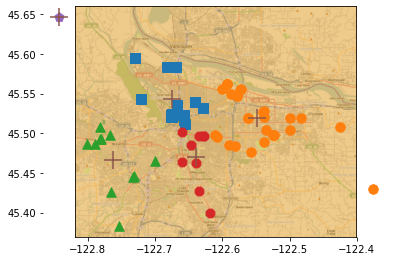

In [13]:
clusterClubs(5)

聚类是一种无监督学习方法，将多个数据点归到多个簇中，其中相似数据点处于统一簇不相似处于不同簇